# Calibration Simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plotly import express as px
import plotly.io as pio
pio.kaleido.scope.mathjax = None  # https://github.com/plotly/plotly.py/issues/3469
from tqdm.auto import tqdm
from calibration import HistogramCalibrator, ScalingBinningCalibrator, OracleCalibrator, BinnedOracleCalibrator, PlattCalibrator, IsotonicCalibrator
from simulation_calibration import GaussianMixtureSimulation, BetaCalibrationSimulation, evaluate
%load_ext autoreload
%autoreload 2

## Appendix E.1. Verifying risk bounds of UMB

In [2]:
sim = GaussianMixtureSimulation()
df = sim.run()

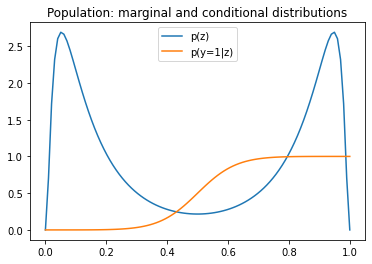

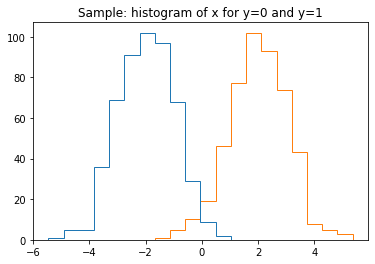

In [3]:
zz = np.linspace(0, 1, 100)
plt.plot(zz, sim.pz(zz), label='p(z)')
plt.plot(zz, sim.py_given_z(zz), label='p(y=1|z)')
plt.legend()
plt.title('Population: marginal and conditional distributions')
plt.show()

z, y = sim.generate_data(1000)
x = sim.f_inv(z)
plt.hist([x[y==0], x[y==1]], histtype='step', stacked=False, bins=20)
plt.title('Sample: histogram of x for y=0 and y=1')
plt.show()

In [4]:
df

,cal,sha,ref,risk,bs,n,B,i
0,0.001179,3.534171e-03,0.00251,0.004714,0.007224,100,6,0
1,0.002162,1.804147e-02,0.00251,0.020204,0.022714,100,6,1
2,0.002611,2.849727e-02,0.00251,0.031108,0.033619,100,6,2
3,0.000839,2.139180e-02,0.00251,0.022230,0.024741,100,6,3
4,0.000065,2.576667e-02,0.00251,0.025832,0.028342,100,6,4
...,...,...,...,...,...,...,...,...
695,0.000001,9.516113e-07,0.00251,0.000002,0.002513,10000000,1000,5
696,0.000002,1.055883e-06,0.00251,0.000003,0.002514,10000000,1000,6
697,0.000001,9.338333e-07,0.00251,0.000002,0.002513,10000000,1000,7
698,0.000001,9.895469e-07,0.00251,0.000002,0.002513,10000000,1000,8


cal vs. B 0.9833785041197238
cal vs. n -0.9886262835902907
sha vs. B -1.8311808737753643


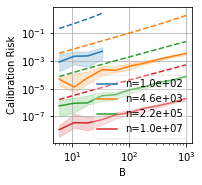

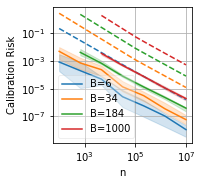

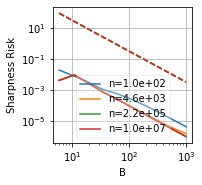

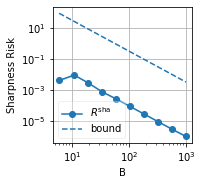

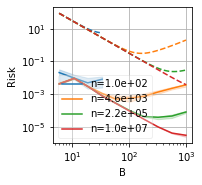

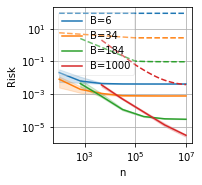

<Figure size 180x180 with 0 Axes>

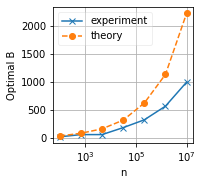

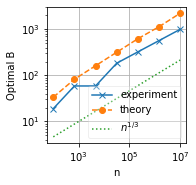

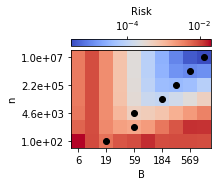

In [5]:
sim.plot(df)

## Appendix E.2. Compare with other recalibration methods
Methods: Platt Scaling, Scaling-binning (Kumar'19), UWB, and UMB

### Simulation 1: Mixture of Gaussians (ommited in the paper)
$$
    \begin{aligned}
    Y &\sim \text{Bernoulli}(0.5), \\
    X \mid Y=0 &\sim \mathcal{N}(-2, 1), \\
    X \mid Y=1 &\sim \mathcal{N}(2, 1), \\
    Z &= \text{sigmoid}(X).
    \end{aligned}
$$


In [6]:
n = 5000
sim = GaussianMixtureSimulation()
df = sim.run_calibrators_asymp(n_list=[n], B_list=np.logspace(1, 3.3, 7, dtype=int), i_list=np.arange(1))
df

,Calibrator,Metric,Value,n,B,i
0,Optimal,cal,0.000000e+00,5000,10,0
1,Optimal,sha,0.000000e+00,5000,10,0
2,Optimal,ref,2.510403e-03,5000,10,0
3,Optimal,risk,0.000000e+00,5000,10,0
4,Optimal,bs,2.510403e-03,5000,10,0
...,...,...,...,...,...,...
170,UMB,cal,4.896681e-03,5000,1995,0
171,UMB,sha,4.949775e-07,5000,1995,0
172,UMB,ref,2.510403e-03,5000,1995,0
173,UMB,risk,4.897176e-03,5000,1995,0


In [7]:
fig = sim.plot_asymp(df)
fig

In [8]:
B = round(n ** (1/3))
print(B)
df_raw = sim.run_calibrators_asymp(n_list=[5000], B_list=[B], i_list=np.arange(100))

17


In [9]:
df_wide, df_str = sim.tabulate(df_raw)
print(df_str)
df_wide

\begin{tabular}{ccccc}
\toprule
Metric ($\times 10^{-3}$) & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & \bfseries 0.062 & \bfseries 0.000 & \bfseries 0.062 & \bfseries 2.573 \\
Hybrid & 0.087 & 4.284 & 4.345 & 6.855 \\
UWB & 0.312 & 0.195 & 0.507 & 3.017 \\
UMB & 0.173 & 4.284 & 4.363 & 6.874 \\
\bottomrule
\end{tabular}



Metric ($\times 10^{-3}$),$\REL$,$\GRP$,$R$,MSE
Platt,0.062234,0.00000,0.062234,2.572637
Hybrid,0.086634,4.28411,4.345000,6.855403
UWB,0.311842,0.19496,0.506802,3.017205
UMB,0.172857,4.28411,4.363205,6.873608


### Simulation 2: Logistic calibration
$$
    \begin{aligned}
    Z &\sim \text{Uniform}[0,1], \\
    Y \mid Z &\sim \text{Bernoulli}(h_{\text{beta}}(Z; 4, 4, 0)),
    \end{aligned}
$$
where
$$
    h_{\text{beta}}(z; a, b, c) = \frac{1}{1 + 1/\left(e^c \frac{z^a}{(1-z)^b}\right)}.
$$

#### Risk vs. B

In [10]:
n = 5000
sim = BetaCalibrationSimulation(a=4, b=4, c=0)
df = sim.run_calibrators_asymp(n_list=[n], B_list=np.logspace(1, 3.3, 7, dtype=int), i_list=np.arange(1))
df

,Calibrator,Metric,Value,n,B,i
0,Optimal,cal,0.000000e+00,5000,10,0
1,Optimal,sha,0.000000e+00,5000,10,0
2,Optimal,ref,1.021612e-02,5000,10,0
3,Optimal,risk,0.000000e+00,5000,10,0
4,Optimal,bs,1.021612e-02,5000,10,0
...,...,...,...,...,...,...
170,UMB,cal,2.206503e-02,5000,1995,0
171,UMB,sha,1.253362e-07,5000,1995,0
172,UMB,ref,1.021612e-02,5000,1995,0
173,UMB,risk,2.206516e-02,5000,1995,0


In [11]:
fig = sim.plot_asymp(df)
fig.write_image('compare_B_logistic.pdf')
fig

#### Fix B and run random seeds to get 90-percentile

In [12]:
n = 5000
B = round(2 * n ** (1/3))  # UMB have optimal B, yet still underperforming than Hybrid
print(B)
df_raw = sim.run_calibrators_asymp(n_list=[5000], B_list=[B], i_list=np.arange(100))

34


In [13]:
df_wide, df_str = sim.tabulate(df_raw)
print(df_str)
df_wide

\begin{tabular}{ccccc}
\toprule
Metric ($\times 10^{-3}$) & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 0.122 & \bfseries 0.000 & \bfseries 0.122 & \bfseries 10.338 \\
Hybrid & \bfseries 0.119 & 0.212 & 0.315 & 10.532 \\
UWB & 0.661 & 0.194 & 0.855 & 11.071 \\
UMB & 0.647 & 0.212 & 0.839 & 11.055 \\
\bottomrule
\end{tabular}



Metric ($\times 10^{-3}$),$\REL$,$\GRP$,$R$,MSE
Platt,0.122294,0.000000,0.122294,10.338415
Hybrid,0.118659,0.212339,0.315471,10.531592
UWB,0.661395,0.193874,0.855270,11.071391
UMB,0.646514,0.212339,0.838940,11.055062


#### Fix B and random seed to plot

/x/home/zeyusun/work/wip/simulation_calibration.py:418: RuntimeWarning:

divide by zero encountered in true_divide



  0%|          | 0/5 [00:00<?, ?it/s]

Metric,$\REL$,$\GRP$,$R$,MSE
Platt,0.000015,0.000000,0.000015,0.010232
Hybrid,0.000014,0.000199,0.000213,0.010429
UWB,0.000499,0.000194,0.000693,0.010909
UMB,0.000546,0.000199,0.000745,0.010961


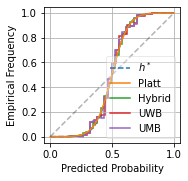

In [14]:
# B = round(2 * n ** (1/3))  # we might prefer small B for visualization
plt.figure(figsize=(2.5, 2.5))
df_wide, df_str, _ = sim.run_calibrators(n=n, B=B, seed=3)
plt.savefig('compare_rd_logistic.pdf', bbox_inches='tight')
df_wide

### Simulation 3: Beta calibration
$$
    \begin{aligned}
    Z &\sim \text{Uniform}[0,1], \\
    Y \mid Z &\sim \text{Bernoulli}(h_{\text{beta}}(Z; 0.1, 4, 0)).
    \end{aligned}
$$

#### Risk vs. B

In [15]:
sim = BetaCalibrationSimulation(a=0.1, b=4, c=0) #m=0.25)
n = 5000
df = sim.run_calibrators_asymp(n_list=[n], B_list=np.logspace(1, 3.3, 7, dtype=int), i_list=np.arange(1))
df

,Calibrator,Metric,Value,n,B,i
0,Optimal,cal,0.000000e+00,5000,10,0
1,Optimal,sha,0.000000e+00,5000,10,0
2,Optimal,ref,1.831218e-02,5000,10,0
3,Optimal,risk,0.000000e+00,5000,10,0
4,Optimal,bs,1.831218e-02,5000,10,0
...,...,...,...,...,...,...
170,UMB,cal,3.814027e-02,5000,1995,0
171,UMB,sha,2.388373e-07,5000,1995,0
172,UMB,ref,1.831218e-02,5000,1995,0
173,UMB,risk,3.814051e-02,5000,1995,0


In [16]:
fig = sim.plot_asymp(df)
fig.write_image('compare_B_beta.pdf')
fig

#### Fix B and run random seeds to get 90-percentile

In [17]:
B = round(n ** (1/3))
print(B)
df_raw = sim.run_calibrators_asymp(n_list=[n], B_list=[B], i_list=np.arange(100))

17


In [18]:
df_wide, df_str = sim.tabulate(df_raw)
print(df_str)
df_wide

\begin{tabular}{ccccc}
\toprule
Metric ($\times 10^{-3}$) & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 3.682 & \bfseries 0.000 & 3.682 & 21.994 \\
Hybrid & 3.117 & 0.251 & 3.360 & 21.672 \\
UWB & 0.572 & 0.238 & 0.810 & 19.122 \\
UMB & \bfseries 0.560 & 0.251 & \bfseries 0.797 & \bfseries 19.109 \\
\bottomrule
\end{tabular}



Metric ($\times 10^{-3}$),$\REL$,$\GRP$,$R$,MSE
Platt,3.681965,0.000000,3.681965,21.994141
Hybrid,3.117253,0.251361,3.359704,21.671880
UWB,0.572079,0.237797,0.809876,19.122052
UMB,0.559846,0.251361,0.797110,19.109286


#### Fix B and random seed to plot

/x/home/zeyusun/work/wip/simulation_calibration.py:418: RuntimeWarning:

divide by zero encountered in true_divide



  0%|          | 0/5 [00:00<?, ?it/s]

\begin{tabular}{ccccc}
\toprule
Metric & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 0.003409 & \bfseries 0.000000 & 0.003409 & 0.021721 \\
Hybrid & 0.002939 & 0.000234 & 0.003173 & 0.021485 \\
UWB & 0.000155 & 0.000238 & 0.000392 & 0.018705 \\
UMB & \bfseries 0.000134 & 0.000234 & \bfseries 0.000368 & \bfseries 0.018680 \\
\bottomrule
\end{tabular}



Metric,$\REL$,$\GRP$,$R$,MSE
Platt,0.003409,0.000000,0.003409,0.021721
Hybrid,0.002939,0.000234,0.003173,0.021485
UWB,0.000155,0.000238,0.000392,0.018705
UMB,0.000134,0.000234,0.000368,0.018680


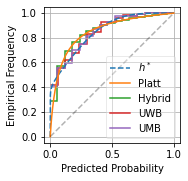

In [19]:
plt.figure(figsize=(2.5, 2.5))
df_wide, df_str, _ = sim.run_calibrators(n=n, B=B, seed=0)
plt.savefig('compare_rd_beta.pdf', bbox_inches='tight')
print(df_str)
df_wide